In this seminar, we will apply the Gaussian mixture model to the problem of grouping people according to their physical parameters.

### Setup

In [ ]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import time
%matplotlib inline

### Data loading

In [ ]:
!wget https://cdn.analyticsvidhya.com/wp-content/uploads/2019/10/Clustering_gmm.csv

--2021-05-19 14:16:47--  https://cdn.analyticsvidhya.com/wp-content/uploads/2019/10/Clustering_gmm.csv
Resolving cdn.analyticsvidhya.com (cdn.analyticsvidhya.com)... 104.26.1.226, 172.67.75.199, 104.26.0.226, ...
Connecting to cdn.analyticsvidhya.com (cdn.analyticsvidhya.com)|104.26.1.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18385 (18K) [text/csv]
Saving to: ‘Clustering_gmm.csv.1’

Clustering_gmm.csv. 100%[===================>]  17.95K  --.-KB/s    in 0.001s  

2021-05-19 14:16:49 (11.7 MB/s) - ‘Clustering_gmm.csv.1’ saved [18385/18385]



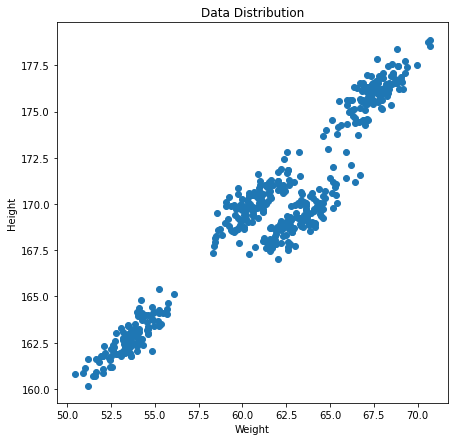

In [ ]:
data = pd.read_csv('Clustering_gmm.csv')

plt.figure(figsize=(7,7))
plt.scatter(data["Weight"],data["Height"])
plt.xlabel('Weight')
plt.ylabel('Height')
plt.title('Data Distribution')
plt.show()

## Brief reminder

## Gaussian mixure Models (GMMs)


GMMs assume that there are a certain number of Gaussian distributions, and each of these distributions represent a cluster. Hence, a Gaussian Mixture Model tends to group the data points belonging to a single distribution together.

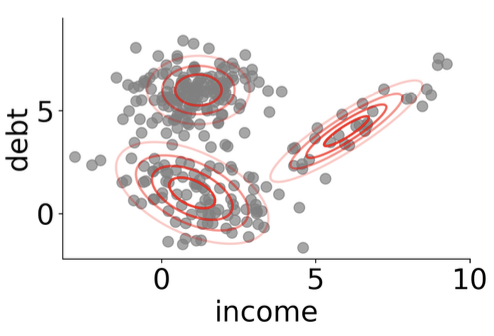

$p(x | \theta) = \pi_1 \mathcal{N} (x|\mu_1, \sigma_1) + \pi_2 \mathcal{N} (x|\mu_2, \sigma_2) + \pi_3 \mathcal{N} (x|\mu_3, \sigma_3)$

$\theta = {\pi_1,\pi_2,\pi_3,μ_1,μ_2,μ_3,\sigma_1,\sigma_2,\sigma_3}$



## Expectation Maximization (EM) algorithm for GMM

Remember, that EM algorithm is a coordinate descent optimization of variational lower bound $\mathcal{L}(\theta, q) = \int q(T) \log\frac{p(X, T|\theta)}{q(T)}dT\to \max$.

<b>E-step</b>:<br>
$\mathcal{L}(\theta, q) \to \max\limits_{q} \Leftrightarrow \mathcal{KL} [q(T) \,\|\, p(T|X, \theta)] \to \min \limits_{q\in Q} \Rightarrow q(T) = p(T|X, \theta)$<br>
<b>M-step</b>:<br> 
$\mathcal{L}(\theta, q) \to \max\limits_{\theta} \Leftrightarrow \mathbb{E}_{q(T)}\log p(X,T | \theta) \to \max\limits_{\theta}$

For GMM, $\theta$ is a set of parameters that consists of mean vectors $\mu_c$, covariance matrices $\Sigma_c$ and priors $\pi_c$ for each component.

Latent variables $T$ are indices of components to which each data point is assigned, i.e. $t_i$  is the cluster index for object $x_i$.

The joint distribution can be written as follows: $\log p(T, X \mid \theta) =  \sum\limits_{i=1}^N \log p(t_i, x_i \mid \theta) = \sum\limits_{i=1}^N \sum\limits_{c=1}^C q(t_i = c) \log \left (\pi_c \, f_{\!\mathcal{N}}(x_i \mid \mu_c, \Sigma_c)\right)$,
where $f_{\!\mathcal{N}}(x \mid \mu_c, \Sigma_c) = \frac{1}{\sqrt{(2\pi)^n|\boldsymbol\Sigma_c|}}
\exp\left(-\frac{1}{2}({x}-{\mu_c})^T{\boldsymbol\Sigma_c}^{-1}({x}-{\mu_c})
\right)$ is the probability density function (pdf) of the normal distribution $\mathcal{N}(x_i \mid \mu_c, \Sigma_c)$.

__________

### Initialization of parameters values

While $\pi$ can use simple uniform initialization, for $\mu$ it is better to choose a random index $i_j$ uniformly from 1 to n for each class and then initialize $\mu_j=X_{i_j}$. 

This ensures that each cluster centroid is inside the support of the underlying distribution and that they are initially spread out randomly throughout the space.

In [ ]:
def initialize(X, k):
    shape = X.shape
    n, m = shape

    pi0 = np.full(shape=k, fill_value=1/k)
        
    random_row = np.random.randint(low=0, high=n, size=k)
    mu0 = [data.iloc[row_index,:] for row_index in random_row ]
    mu0 = np.array(mu0)
    sigma0 = np.array([np.cov(X.T) for _ in range(k)])

    return pi0, mu0, sigma0

### E-step
In this step we need to estimate the posterior distribution over the latent variables with fixed values of parameters: $q_i(t_i) = p(t_i \mid x_i, \theta)$. We assume that $t_i$ equals to the cluster index of the true component of the $x_i$ object. To do so we need to compute $\gamma_{ic} = p(t_i = c \mid x_i, \theta)$. Note that $\sum\limits_{c=1}^C\gamma_{ic}=1$.

In [ ]:
def E_step(X, pi, mu, sigma):
    """
    Performs E-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    pi: (C), mixture component weights 
    mu: (C x d), mixture component means
    sigma: (C x d x d), mixture component covariance matrices
    
    Returns:
    gamma: (N x C), probabilities of clusters for objects
    """
    N = X.shape[0] # number of objects
    C = pi.shape[0] # number of clusters
    d = mu.shape[1] # dimension of each object
    gamma = np.zeros((N, C)) # distribution q(T)

    likelihood = np.zeros((N, C))
    for c in range(C):
        model = multivariate_normal(mean=mu[c, :], cov=sigma[c, :])
        likelihood[:, c] = model.pdf(X) #likelihood of seeing data point j given cluster c
    
    likelihood *= pi
    gamma = likelihood / np.sum(likelihood, axis=1, keepdims=True) #gamma[j, k] is the responsibility of cluster c for data point j
    
    return gamma

### M-step

In M-step we need to maximize $\mathbb{E}_{q(T)}\log p(X,T | \theta)$ with respect to $\theta$. In our model this means that we need to find optimal values of $\pi$, $\mu$, $\Sigma$. 

<b>Task:</b> : compute \mu for every cluster using this formula: 
$\frac{\sum{p(t_i = c \mid x_i, \theta) *x_i}}{\sum{p(t_i = c \mid x_i, \theta)}}$.

HINT: use *.reshape(N,1)* in order to transform matrix to a vector

In [ ]:
def M_step(X, gamma):
    """
    Performs M-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    
    Returns:
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    ### YOUR CODE HERE
    ## Initialaze pi, mu and sigma filled with zeros
    pi = ...
    mu = ...
    sigma = ...

    for c in range(C):
        posterior = np.sum(gamma[:, c])
        
        mu[c, :] = ...
        sigma[c, :] = np.sum([gamma[i,c] * np.outer(X[i,:] - mu[c,:], X[i,:] - mu[c,:]) for i in range(N)], axis=0) / posterior
        pi[c] = posterior / N
    
    return pi, mu, sigma

### Loss function

Finally, we need a function to track the convergence. For this we use the variational lower bound $ \mathcal{L} $. We will stop our EM iterations when $ \mathcal{L} $ reaches saturation. Usually it only takes about 10-20 iterations to converge.


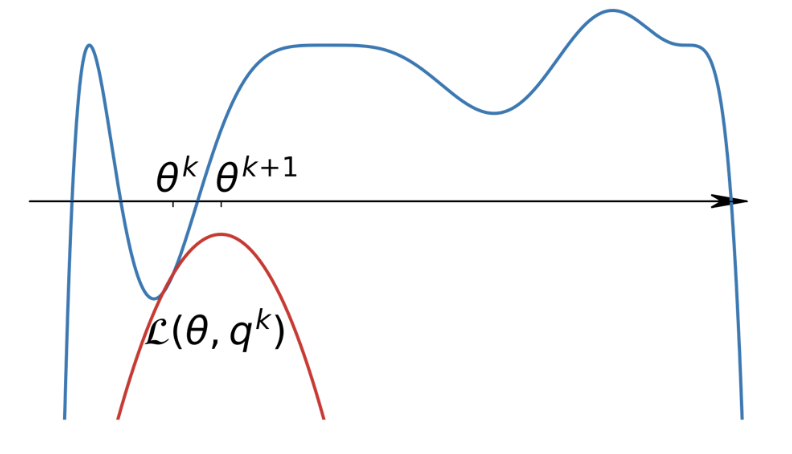

<b>Task:</b> Implement a function that will compute $\mathcal{L}$ using template below.

$$\mathcal{L} = \sum_{i=1}^{N} \gamma_{ic} (\log \pi_c + \log f_{\!\mathcal{N}}(x_i \mid \mu_c, \Sigma_c)) - \sum_{i=1}^{N} \log \gamma_{ic}$$

HINT: use *model.logpdf(X[n, :])* to compute $\log f_{\!\mathcal{N}}(x_i \mid \mu_c, \Sigma_c)$

In [ ]:
def compute_vlb(X, pi, mu, sigma, gamma):
    """
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    
    Returns value of variational lower bound
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    loss = 0

    for c in range(C):
        model = multivariate_normal(mu[c], sigma[c], allow_singular=True)
        for n in range(N):
            ### YOUR CODE HERE
            loss += ...
    
    return loss

In [ ]:
pi0, mu0, sigma0 = initialize(data, 4) 
gamma = E_step(data, pi0, mu0, sigma0)
labels = gamma.argmax(1)
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=labels, s=30)
plt.axis('equal')
plt.show()

Now that we have step E, step M and VLB, we can implement a learning loop. We initialize the values of $ \pi $, $ \mu $ and $ \Sigma $ with some random numbers, train until $ \mathcal{L} $ stops changing, and return the resulting points.

In [ ]:
import math
def train_EM(X, C, rtol=1e-3, max_iter=10, restarts=5):
    '''
    Starts with random initialization *restarts* times
    Runs optimization until saturation with *rtol* reached
    or *max_iter* iterations were made.
    
    X: (N, d), data points
    C: int, number of clusters
    '''
    N = X.shape[0] # number of objects
    d = X.shape[1] # dimension of each object
    best_loss = -999999
    best_pi = None
    best_mu = None
    best_sigma = None
    for _ in range(restarts):
        try:
            pi, mu, sigma = initialize(X, C)
            prev_loss = None
            for i in range(max_iter):
                gamma = E_step(X, pi, mu, sigma)

                gamma = pd.DataFrame(gamma)
                pi, mu, sigma = M_step(X, gamma)
                pi = pi / np.sum(pi)
                loss = compute_vlb(X, pi, mu, sigma, gamma)
                if not math.isnan(loss) and loss > best_loss:
                    best_loss = loss
                    best_mu = mu
                    best_pi = pi
                    best_sigma = sigma
                print("Iteration {}, loss: {}".format(i, loss))

                if prev_loss is not None:
                    diff = np.abs(loss - prev_loss)
                    if diff < rtol:
                        break
                prev_loss = loss
        except np.linalg.LinAlgError:
            print("Singular matrix: components collapsed")
            continue

In [ ]:
best_loss, best_pi, best_mu, best_sigma = train_EM(data, 4)

In [ ]:
gamma = E_step(data, best_pi, best_mu, best_sigma)
labels = gamma.argmax(1)
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=labels, s=30)
plt.axis('equal')
plt.show()

## How many Gaussians?

GMM requires the user to specify the number of components (clusters) before training the model. Here, we can use the Aikaki Information Criterion (AIC) or the Bayesian Information Criterion (BIC) to aid us in this decision. Let  $𝐿$
be the maximum value of the likelihood function for the model, $ 𝑝$
be the number of estimated parameters in the model and  $𝑁$
be the total number of data points.

Then the AIC value of the model is the following:
$AIC=2⋅𝑝−2⋅ln(𝐿)$

And the BIC value is denoted as:
$BIC=−2⋅ln(𝐿)+𝑝⋅ln(𝑁)$

For both evaluation criteron, the lower the better.

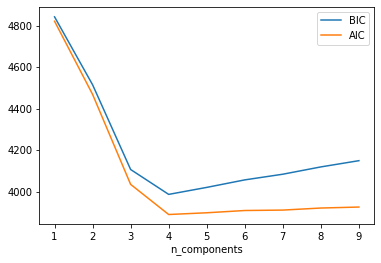

In [ ]:
n_components = np.arange(1, 10)
clfs = [GaussianMixture(n, max_iter = 1000).fit(data) for n in n_components]
bics = [clf.bic(data) for clf in clfs]
aics = [clf.aic(data) for clf in clfs]

plt.plot(n_components, bics, label = 'BIC')
plt.plot(n_components, aics, label = 'AIC')
plt.xlabel('n_components')
plt.legend()
plt.show()